# Project 3 - Spatial Analyis and Spatial Auto-correlation
### Lorn Jaeger


Get the list of hdf5 files

In [ ]:
from pathlib import Path

dpath = Path("/run/host/run/data_raid5/scratch/wsts_temp/")

files = []

for dir in sorted(dpath.iterdir()):
    if dir.is_dir():
        for file in sorted(dir.iterdir()):
            if file.is_file():
                files.append(file)

print(f"{len(files)} fires")

Turn hdf5 files to tabular data. 

In [2]:
import h5py
import numpy as np
import pandas as pd

feature_names = [
    'M11', 'I2', 'I1', 'NDVI', 'EVI2',
    'precip', 'wind_speed', 'wind_dir',
    'temp_min', 'temp_max', 'ERC',
    'specific_humidity', 'slope', 'aspect',
    'elevation', 'PDSI', 'landcover',
    'forecast_precip', 'forecast_wind_speed',
    'forecast_wind_dir', 'forecast_temp',
    'forecast_specific_humidity',
    'active_fire_count'
]

rows = []

for file in files:
    with h5py.File(file, "r") as r:
        data = r["data"]                      
        dates = r["data"].attrs["img_dates"]   
        fire_id = r["data"].attrs["fire_name"]
        lon, lat = r["data"].attrs["lnglat"]     

        for i, date in enumerate(dates):
            raster = data[i]                   
    
            b23 = raster[22]
            mask = b23 != 0
            num_active = int(mask.sum())

            if num_active == 0:
                full_mask = np.ones_like(mask, dtype=bool)
            else:
                full_mask = mask

            masked_vals = raster[:22][:, full_mask]   
            means = masked_vals.mean(axis=1)

            lc_vals = raster[16][full_mask].astype(int, copy=False)
            majority_lc = np.bincount(lc_vals).argmax()
            means[16] = majority_lc

            row = list(means) + [num_active]

            rows.append({
                "fire_id": fire_id,
                "date": str(date),
                "lat": lat,
                "lon": lon,
                **{feature_names[j]: row[j] for j in range(23)}
            })

df = pd.DataFrame(rows)
df
df.to_csv("output.csv", index=False)

Fill in NaN values

In [3]:
df_filled = df.copy()

num_cols = df_filled.select_dtypes(include=[np.number]).columns

global_means = df_filled[num_cols].mean()

for col in num_cols:
    fire_means = df_filled.groupby("fire_id")[col].transform("mean")
    
    fallback = global_means[col]
    col_fill = fire_means.fillna(fallback)
    
    df_filled[col] = df_filled[col].fillna(col_fill)

Add in the next day fires.

In [ ]:
df = df_filled.copy()
df = df.sort_values(["fire_id", "date"])
df["next_day_fire"] = df.groupby("fire_id")["active_fire_count"].shift(-1)
df = df.dropna(subset=["next_day_fire"])
df["next_day_fire"] = df["next_day_fire"].astype(float)

At this point we have our final list of fires. Now we can merge our other data.

In [3]:
import numpy as np
import pandas as pd
import rasterio
from scipy.spatial import cKDTree

# -----------------------------------------------------------
# helper to convert lat/lon → 3D Earth coordinates
def to_xyz(lat, lon):
    lat_r = np.radians(lat)
    lon_r = np.radians(lon)
    x = np.cos(lat_r) * np.cos(lon_r)
    y = np.cos(lat_r) * np.sin(lon_r)
    z = np.sin(lat_r)
    return np.column_stack((x, y, z))

# -----------------------------------------------------------
fires = pd.read_csv("../filled_output.csv")

coords = fires[["lat","lon"]].drop_duplicates()
u_lat = coords["lat"].values
u_lon = coords["lon"].values

# -----------------------------------------------------------
# Load GHSL pop for CONUS
rpath = "../data/ghsl/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif"
with rasterio.open(rpath) as src:
    conus_bounds = (-125, 24, -66.5, 50)
    window = rasterio.windows.from_bounds(*conus_bounds, transform=src.transform)
    pop = src.read(1, window=window)
    transform = src.window_transform(window)

# masks
low_mask  = (pop < 6.17)
med_mask  = (pop >= 6.17) & (pop < 49.42)
high_mask = (pop >= 49.42)

# convert pixel centers → lat/lon
rows, cols = np.indices(pop.shape)
xs, ys = rasterio.transform.xy(transform, rows, cols)
xs = np.array(xs).ravel()
ys = np.array(ys).ravel()

def mask_to_latlon(mask):
    m = mask.ravel()
    return ys[m], xs[m]

low_lat,  low_lon  = mask_to_latlon(low_mask)
med_lat,  med_lon  = mask_to_latlon(med_mask)
high_lat, high_lon = mask_to_latlon(high_mask)

# -----------------------------------------------------------
# Build KD trees using haversine-safe 3D coordinates
low_tree  = cKDTree(to_xyz(low_lat,  low_lon))
med_tree  = cKDTree(to_xyz(med_lat,  med_lon))
high_tree = cKDTree(to_xyz(high_lat, high_lon))

# query points in 3D
query_xyz = to_xyz(u_lat, u_lon)

# -----------------------------------------------------------
# nearest neighbor in 3D great-circle space
d_low,  _ = low_tree.query(query_xyz,  k=1)
d_med,  _ = med_tree.query(query_xyz,  k=1)
d_high, _ = high_tree.query(query_xyz, k=1)

# convert chord length → great-circle meters
# angular distance = 2*arcsin(chord/2)
earth_radius = 6371000.0
ang_low  = 2 * np.arcsin(d_low  / 2)
ang_med  = 2 * np.arcsin(d_med  / 2)
ang_high = 2 * np.arcsin(d_high / 2)

coords["dist_low"]  = ang_low  * earth_radius
coords["dist_med"]  = ang_med  * earth_radius
coords["dist_high"] = ang_high * earth_radius

fires = fires.merge(coords, on=["lat","lon"], how="left")
fires.to_csv("with_wui.csv", index=False)

In [7]:
fires.to_csv("with_wui.csv", index=False)

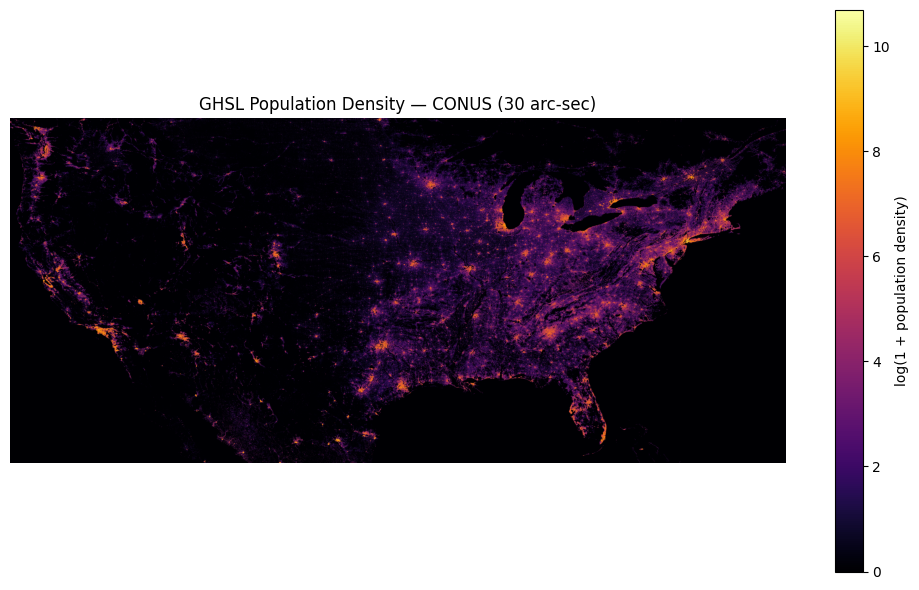

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds

# -----------------------------------------------------------
# Path to your GHSL raster
rpath = "../data/ghsl/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif"

# CONUS bounds in WGS84
conus_bounds = (-125.0, 24.0, -66.5, 50.0)

# -----------------------------------------------------------
# Load and window-read only the US region
with rasterio.open(rpath) as src:
    window = from_bounds(*conus_bounds, transform=src.transform)
    arr = src.read(1, window=window).astype(float)

# -----------------------------------------------------------
# Visualization trick: log-scale stretch to make cities visible
arr_plot = np.log1p(arr)        # log(1 + x) avoids zeros
arr_plot[arr == 0] = 0          # keep ocean flat

# -----------------------------------------------------------
# Plot
plt.figure(figsize=(10, 6))
plt.imshow(arr_plot, cmap="inferno", origin="upper")
plt.colorbar(label="log(1 + population density)")
plt.title("GHSL Population Density — CONUS (30 arc-sec)")
plt.axis("off")
plt.tight_layout()
plt.show()


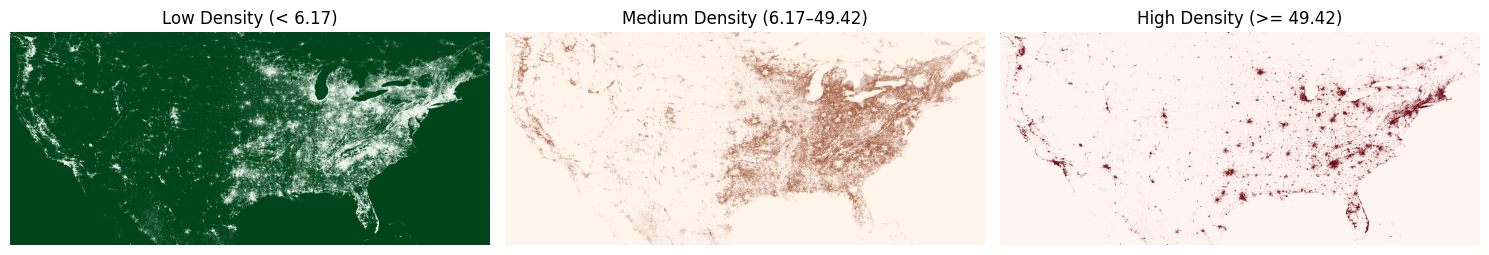

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds

# -----------------------------------------------------------
# Path to GHSL population raster (WGS84, 30 arc-sec)
rpath = "../data/ghsl/GHS_POP_E2015_GLOBE_R2023A_4326_30ss_V1_0.tif"

# CONUS bounding box
conus_bounds = (-125.0, 24.0, -66.5, 50.0)

# -----------------------------------------------------------
# Load only the US region
with rasterio.open(rpath) as src:
    window = from_bounds(*conus_bounds, transform=src.transform)
    pop = src.read(1, window=window).astype(float)

# -----------------------------------------------------------
# Masks (your thresholds)
low_mask  = (pop < 6.17)
med_mask  = (pop >= 6.17) & (pop < 49.42)
high_mask = (pop >= 49.42)

# -----------------------------------------------------------
# Plot three masks
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(low_mask, cmap="Greens", origin="upper")
plt.title("Low Density (< 6.17)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(med_mask, cmap="Oranges", origin="upper")
plt.title("Medium Density (6.17–49.42)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(high_mask, cmap="Reds", origin="upper")
plt.title("High Density (>= 49.42)")
plt.axis("off")

plt.tight_layout()
plt.show()
